In [1]:
import os

WORKING_DIR = 'C:/Users/malik.kalembasi/OneDrive - Odine Solutions/Desktop/itu/machine_learning/term_project'
os.chdir(WORKING_DIR)
print(os.getcwd())

C:\Users\malik.kalembasi\OneDrive - Odine Solutions\Desktop\itu\machine_learning\term_project


In [2]:
# IMPORTS & ENV VARS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = os.path.join(WORKING_DIR, 'data')

In [3]:
# LOAD DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan")
print("features: ", sj_train_features.shape)
print("labels  : ", sj_train_labels.shape)

print("\nIquitos")
print("features: ", iq_train_features.shape)
print("labels  : ", iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [4]:
sj_train_features.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
     19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
     20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
     21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
     22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1990 18                         12.42             297.572857   
     19                         22.82             298.211429   
     20                         34.54             298.781429   
     21                         15.36             298.987143   
     22                          7.52             299.518571   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1990 18                     297.742857                   292.414286   
     19                     298.442857                   293.951429   
     20                     298.878571                   295.434286   
     21                     299.228571                   295.310000   
     22                     299.664286                   295.821429   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1990 18                              299.8  ...   
     19                              300.9  ...   
     20                              300.5  ...   
     21                              301.4  ...   
     22                              301.9  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
1990 18                                    32.00   
     19                                    17.94   
     20                                    26.10   
     21                                    13.90   
     22                                    12.20   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1990 18                                     73.365714   
     19                                     77.368571   
     20                                     82.052857   
     21                                     80.337143   
     22                                     80.460000   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
1990 18                                 12.42   
     19                                 22.82   
     20                                 34.54   
     21                                 15.36   
     22                                  7.52   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1990 18                                      14.012857           2.628571   
     19                                      15.372857           2.371429   
     20                                      16.848571           2.300000   
     21                                      16.672857           2.428571   
     22                                      17.210000           3.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
1990 18                   25.442857                 6.900000   
     19                   26.714286                 6.371429   
     20                   26.714286                 6.485714   
     21                   27.471429                 6.771429   
     22                   28.942857                 9.371429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
year weeko

In [5]:
print("San Juan Features:", sj_train_features.columns.tolist())
print("San Juan Labels:", sj_train_labels.columns.tolist())

San Juan Features: ['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']
San Juan Labels: ['total_cases']


## XGBoost Pipeline Plan

Here is the roadmap to build the XGBoost model for Dengue prediction:

1.  **Data Preparation & Indexing**:
    *   Merge features and labels.
    *   **Fix Index**: Convert `week_start_date` to a Datetime Index to facilitate time-series operations.
    *   **Imputation**: Handle missing values (using forward fill `ffill` as this is time-series data).
2.  **Feature Engineering**:
    *   **Lag Features**: Create lagged versions of climate variables (e.g., humidity 1 week ago).
    *   **Rolling Features**: Create rolling averages/std dev (e.g., 4-week rolling mean of temperature).
    *   **Time Features**: Ensure `month` and `weekofyear` are available.
3.  **Feature Selection**:
    *   Remove highly correlated features or use feature importance to select the best subset.
4.  **Model Training & Cross-Validation**:
    *   Use `TimeSeriesSplit` to validate the model without data leakage (training on past, testing on future).
    *   Train separate XGBoost models for **San Juan (sj)** and **Iquitos (iq)**.
5.  **Hyperparameter Tuning**:
    *   Optimize XGBoost parameters (learning rate, max depth, subsample, etc.) using `GridSearchCV` or `RandomizedSearchCV`.

### Handling the Index
The current index is a MultiIndex `(city, year, weekofyear)`. To use time-series functionality (like rolling windows), we will:
1.  Reset the index to make `year` and `weekofyear` columns.
2.  Convert `week_start_date` to a `datetime` object.
3.  Set `week_start_date` as the new index.


In [6]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [7]:
def preprocess_city_data(features, labels=None):
    """
    Merges features and labels, converts week_start_date to index,
    and handles missing values.
    """
    # 1. Merge features and labels if labels are provided
    if labels is not None:
        df = features.join(labels)
    else:
        df = features.copy()
    
    # 2. Reset index to move 'year' and 'weekofyear' from index to columns
    # This preserves them as features.
    df.reset_index(inplace=True)
    
    # 3. Convert week_start_date to datetime
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    # 4. Set week_start_date as index
    df.set_index('week_start_date', inplace=True)
    
    # 5. Drop 'city' column as it's constant for each model and not numeric
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    
    # 6. Fill Missing Values (Forward Fill for time series)
    df = df.ffill()
    
    return df

# Apply to San Juan and Iquitos
sj_train = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan Preprocessed Shape:", sj_train.shape)
print("Iquitos Preprocessed Shape:", iq_train.shape)
sj_train.head()

San Juan Preprocessed Shape: (936, 23)
Iquitos Preprocessed Shape: (520, 23)


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [8]:
def create_features(df, lag_weeks=[1, 2, 3], rolling_weeks=[4, 8]):
    """
    Creates lag and rolling window features.
    """
    df_eng = df.copy()
    
    # List of columns to create features for (exclude labels and non-numeric if any)
    # Typically climate variables
    feature_cols = [c for c in df.columns if c not in ['total_cases', 'year', 'weekofyear']]
    
    new_features = []
    
    for col in feature_cols:
        # Lag features
        for lag in lag_weeks:
            new_features.append(
                df_eng[col].shift(lag).rename(f'{col}_lag_{lag}')
            )
            
        # Rolling features
        for window in rolling_weeks:
            new_features.append(
                df_eng[col].rolling(window=window).mean().rename(f'{col}_rolling_mean_{window}')
            )
            new_features.append(
                df_eng[col].rolling(window=window).std().rename(f'{col}_rolling_std_{window}')
            )
            
    # Concatenate all new features at once to avoid PerformanceWarning (fragmentation)
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
            
    # Drop rows with NaNs created by lag/rolling (or fill them)
    # For training, we usually drop the initial rows.
    df_eng.dropna(inplace=True)
    
    return df_eng

# Example usage:
sj_train_eng = create_features(sj_train)
iq_train_eng = create_features(iq_train)

print("San Juan Engineered Shape:", sj_train_eng.shape)
print("Iquitos Engineered Shape:", iq_train_eng.shape)

San Juan Engineered Shape: (929, 163)
Iquitos Engineered Shape: (513, 163)


## 3. Feature Selection & Data Splitting

We will separate the target variable `total_cases` from the features. We will also split the data into training and testing sets based on time (since this is a time-series problem, we cannot shuffle the data).

In [9]:
def split_data(df, target_col='total_cases', test_size=0.2):
    """
    Splits data into X and y, and then into train and test sets (time-based).
    """
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Time-based split
    split_index = int(len(df) * (1 - test_size))
    
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    return X_train, X_test, y_train, y_test

# Split San Juan
X_train_sj, X_test_sj, y_train_sj, y_test_sj = split_data(sj_train_eng)

# Split Iquitos
X_train_iq, X_test_iq, y_train_iq, y_test_iq = split_data(iq_train_eng)

print("San Juan Train/Test Shapes:", X_train_sj.shape, X_test_sj.shape)
print("Iquitos Train/Test Shapes:", X_train_iq.shape, X_test_iq.shape)

San Juan Train/Test Shapes: (743, 162) (186, 162)
Iquitos Train/Test Shapes: (410, 162) (103, 162)


## 4. Model Training & Cross-Validation

We will train an XGBoost regressor. Since we are predicting counts (non-negative integers), we can use the `reg:squarederror` objective, or potentially `count:poisson`. For now, we'll stick to standard regression and ensure predictions are non-negative.

We'll use `TimeSeriesSplit` for cross-validation to ensure we respect the temporal order of observations.

In [10]:
def train_evaluate_xgboost(X_train, y_train, X_test, y_test, params=None):
    """
    Trains an XGBoost model and evaluates it.
    """
    if params is None:
        params = {
            'objective': 'reg:squarederror',
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 5,
            'random_state': 42,
            'early_stopping_rounds': 10  # Moved to params for XGBoost 2.0+ compatibility
        }
        
    model = xgb.XGBRegressor(**params)
    
    # Train
    # Note: early_stopping_rounds is passed to constructor, but we must provide eval_set here
    model.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)
    
    # Predict
    # XGBoost automatically uses the best model if early stopping was triggered
    predictions = model.predict(X_test)
    
    # Ensure non-negative predictions
    predictions = np.maximum(predictions, 0)
    
    # Evaluate
    mae = mean_absolute_error(y_test, predictions)
    
    return model, mae, predictions

# Train Baseline Models
print("Training San Juan Baseline...")
model_sj, mae_sj, preds_sj = train_evaluate_xgboost(X_train_sj, y_train_sj, X_test_sj, y_test_sj)
print(f"San Juan MAE: {mae_sj:.4f}")

print("\nTraining Iquitos Baseline...")
model_iq, mae_iq, preds_iq = train_evaluate_xgboost(X_train_iq, y_train_iq, X_test_iq, y_test_iq)
print(f"Iquitos MAE: {mae_iq:.4f}")

Training San Juan Baseline...
San Juan MAE: 18.3970

Training Iquitos Baseline...
Iquitos MAE: 7.0692


## 5. Hyperparameter Tuning

Now we will use `GridSearchCV` with `TimeSeriesSplit` to find better hyperparameters.

In [11]:
def tune_xgboost(X, y):
    """
    Performs Grid Search with TimeSeriesSplit.
    """
    # Define parameter grid
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=3)
    
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               cv=tscv, scoring='neg_mean_absolute_error', 
                               verbose=1, n_jobs=-1)
    
    grid_search.fit(X, y)
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best MAE (CV):", -grid_search.best_score_)
    
    return grid_search.best_estimator_

# Tune San Juan (using training set only to avoid leakage)
print("Tuning San Juan Model...")
best_model_sj = tune_xgboost(X_train_sj, y_train_sj)

# Tune Iquitos
print("\nTuning Iquitos Model...")
best_model_iq = tune_xgboost(X_train_iq, y_train_iq)

Tuning San Juan Model...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best MAE (CV): 31.80454699198405

Tuning Iquitos Model...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best MAE (CV): 6.4054059982299805


## Final Evaluation

Let's evaluate the tuned models on the hold-out test set.

San Juan Tuned MAE: 19.5477
Iquitos Tuned MAE: 8.0685


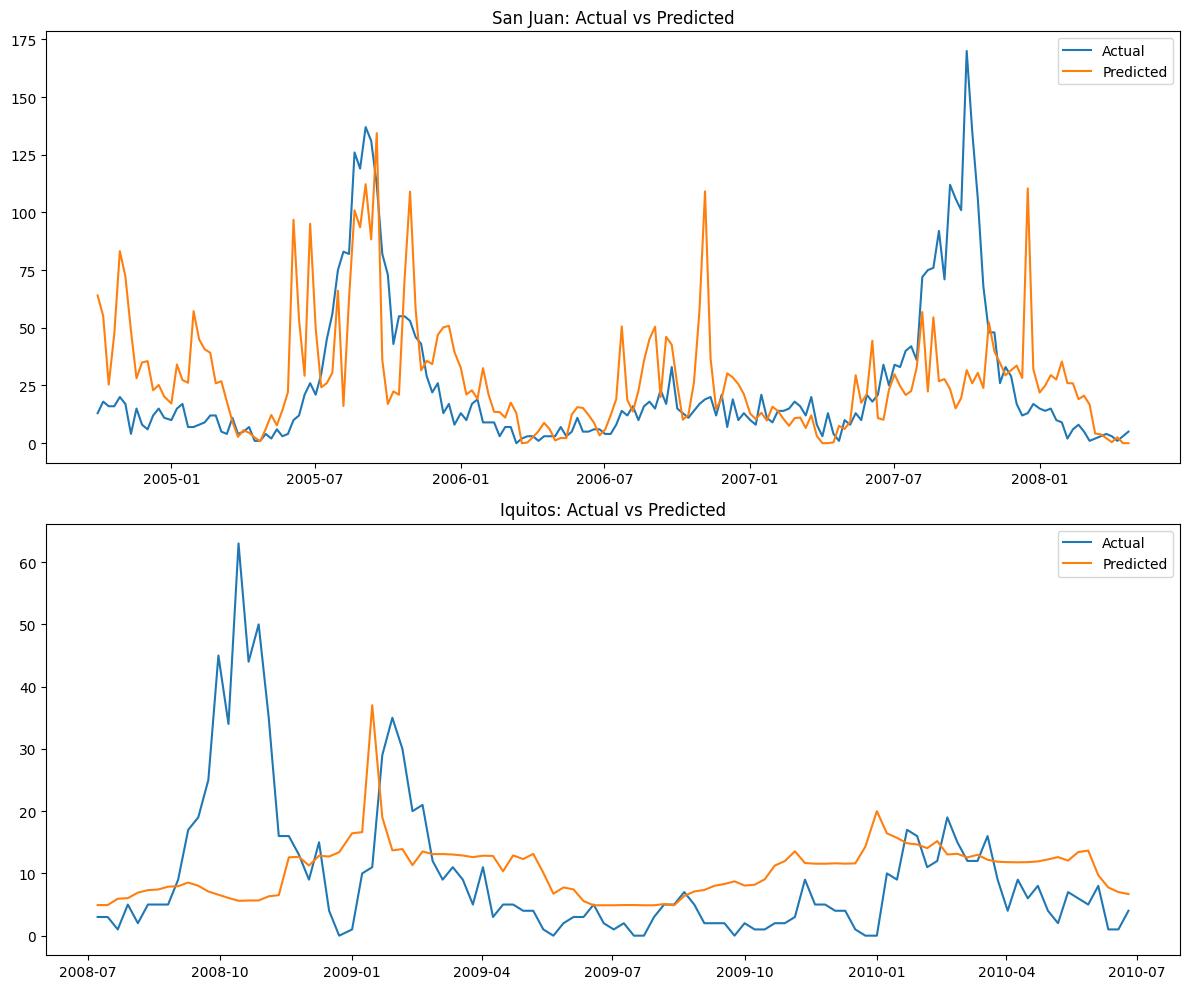

In [12]:
# Evaluate Tuned San Juan
preds_sj_tuned = best_model_sj.predict(X_test_sj)
preds_sj_tuned = np.maximum(preds_sj_tuned, 0)
mae_sj_tuned = mean_absolute_error(y_test_sj, preds_sj_tuned)
print(f"San Juan Tuned MAE: {mae_sj_tuned:.4f}")

# Evaluate Tuned Iquitos
preds_iq_tuned = best_model_iq.predict(X_test_iq)
preds_iq_tuned = np.maximum(preds_iq_tuned, 0)
mae_iq_tuned = mean_absolute_error(y_test_iq, preds_iq_tuned)
print(f"Iquitos Tuned MAE: {mae_iq_tuned:.4f}")

# Plot Results
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# San Juan
ax[0].plot(y_test_sj.index, y_test_sj, label='Actual')
ax[0].plot(y_test_sj.index, preds_sj_tuned, label='Predicted')
ax[0].set_title('San Juan: Actual vs Predicted')
ax[0].legend()

# Iquitos
ax[1].plot(y_test_iq.index, y_test_iq, label='Actual')
ax[1].plot(y_test_iq.index, preds_iq_tuned, label='Predicted')
ax[1].set_title('Iquitos: Actual vs Predicted')
ax[1].legend()

plt.tight_layout()
plt.show()

In [13]:
# 1. Load Test Data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])

sj_test_features = test_features.loc['sj']
iq_test_features = test_features.loc['iq']

# 2. Preprocess Test Data
sj_test = preprocess_city_data(sj_test_features)
iq_test = preprocess_city_data(iq_test_features)

# 3. Feature Engineering for Test Data (handling lags)
def prepare_test_features(train_df, test_df, rolling_weeks=[4, 8]):
    """
    Combines train tail with test to generate features without NaNs in test.
    """
    # We need enough history for the largest window
    max_window = max(rolling_weeks) + 10 # buffer
    
    # Get last part of training data (features only)
    # Ensure we only take columns present in test (exclude target if present)
    train_subset = train_df[test_df.columns].tail(max_window)
    
    # Concatenate
    combined = pd.concat([train_subset, test_df])
    
    # Create features
    combined_eng = create_features(combined)
    
    # Slice back the test part
    # We use the index of test_df to slice. 
    # Note: create_features drops rows with NaNs (the beginning of combined).
    # Since we added buffer from train, the test part should be fully preserved.
    test_eng = combined_eng.loc[test_df.index]
    
    return test_eng

print("Generating Test Features...")
sj_test_eng = prepare_test_features(sj_train, sj_test)
iq_test_eng = prepare_test_features(iq_train, iq_test)

print("San Juan Test Shape:", sj_test_eng.shape)
print("Iquitos Test Shape:", iq_test_eng.shape)

# 4. Predict
sj_preds_final = best_model_sj.predict(sj_test_eng)
sj_preds_final = np.maximum(sj_preds_final, 0).astype(int)

iq_preds_final = best_model_iq.predict(iq_test_eng)
iq_preds_final = np.maximum(iq_preds_final, 0).astype(int)

# 5. Create Submission
submission = pd.read_csv(os.path.join(DATA_DIR, "submission_format.csv"), index_col=[0, 1, 2])

# Assign values
submission.loc['sj', 'total_cases'] = sj_preds_final
submission.loc['iq', 'total_cases'] = iq_preds_final

# 6. Save
submission_path = os.path.join(WORKING_DIR, 'results', 'submission_xgboost.csv')
submission.to_csv(submission_path)
print(f"Submission saved to {submission_path}")
submission.head()

Generating Test Features...
San Juan Test Shape: (260, 162)
Iquitos Test Shape: (156, 162)
Submission saved to C:/Users/malik.kalembasi/OneDrive - Odine Solutions/Desktop/itu/machine_learning/term_project\results\submission_xgboost.csv


C:\Users\malik.kalembasi\AppData\Local\Temp\ipykernel_16772\509278391.py:55: PerformanceWarning: indexing past lexsort depth may impact performance.
  submission.loc['sj', 'total_cases'] = sj_preds_final
C:\Users\malik.kalembasi\AppData\Local\Temp\ipykernel_16772\509278391.py:56: PerformanceWarning: indexing past lexsort depth may impact performance.
  submission.loc['iq', 'total_cases'] = iq_preds_final


total_cases
city year weekofyear             
sj   2008 18                    7
          19                    6
          20                  133
          21                  137
          22                   13